In [1]:
# 获取数据
%reload_ext autoreload
%autoreload 2
import sys
# 替换为fun.py实际所在的绝对路径（比如："D:/projects/common_code"） D:\桌面\策略\fun.py
sys.path.append("D://桌面/策略")
from fun import *
import polars as pl
import pandas as pd
import datetime as dt
import time 


start_date = dt.date(2022,1,1)
end_date = dt.date(2025,1,1)

# 获取指定日期的日线数据
stock_data = read_day_data(start_date=start_date,end_date=end_date,file_path='ts_stock_all_data')
adj_data = read_day_data(start_date=start_date,end_date=end_date,file_path='ts_adj')
stock_data = stock_data.drop_nulls(subset=['open','close','pre_close','limit_up','limit_down']).join(
    adj_data.select(['trading_date','code','adj_factor']),
    on=['trading_date','code'],
    how='left'
).with_columns(
    adjusted_close = pl.col('close') * pl.col('adj_factor')
)
close = stock_data.to_pandas().pivot(index='trading_date',columns='code',values='adjusted_close')

In [3]:

def cal_rskew(start_date,end_date):
    """根据pl.stockdata计算高频偏度因子rskew，返回日频DataFrame"""
    import polars as pl
    stock_data =read_min_data(start_time=start_date,end_time=end_date)
    market_val = read_day_data(start_date=start_date,end_date=end_date).with_columns(
        pl.col("float_mv").log().alias("log_mv")  # 计算市值对数
    ).select("code", "trading_date", "log_mv")

    # 1. 计算分钟对数收益并过滤空值
    df_with_r = stock_data.sort(["code", "trading_date", "datetime"]).with_columns(
        r = pl.col("close").log() - pl.col("close").log().shift(1),
    ).filter(pl.col("r").is_not_null())

    # 2. 按股票+交易日分组，计算当日原始rskew
    daily_rskew = df_with_r.group_by(["code", "trading_date"]).agg(
        r_mean = pl.col("r").mean(),
        r_count = pl.col("r").count(),
        r_sum_sq = ((pl.col("r") - pl.col("r").mean()) ** 2).sum(),
        r_sum_cu = ((pl.col("r") - pl.col("r").mean()) ** 3).sum(),
    ).with_columns(
        rskew = (pl.col("r_count").sqrt() * pl.col("r_sum_cu")) / (pl.col("r_sum_sq") ** 1.5),
    ).filter(
        pl.col("r_count") >= 10,  # 过滤有效分钟数不足的交易日
        pl.col("r_sum_sq") != 0    # 避免除以0
    ).select("code", "trading_date", "r_count", "rskew")

    # ===================== 修正：3. 市值中性化（用map_groups替代apply） =====================
    # 3.1 关联市值数据（确保每个[code, trading_date]都有市值）
    daily_rskew_with_mv = daily_rskew.join(
        market_val, 
        on=["code", "trading_date"], 
        how="inner"  # 只保留有市值数据的样本，避免空值
    )

    # 3.2 定义分组内回归函数（供map_groups调用）
    def neutralize_by_mv(df: pl.DataFrame,x_column='rskew',y_column='log_mv') -> pl.DataFrame:
        """按交易日分组，对rskew做市值中性化（线性回归取残差）"""
        # 跳过单样本分组（无法回归）
        if len(df) <= 1:
            return df.with_columns(resid=pl.lit(0.0))
        
        # 拟合线性回归：rskew ~ log_mv
        try:
            model = pl.lm(pl.col(x_column), pl.col(y_column), data=df)
            a, b = model.params  # 截距a，斜率b
            # 计算残差（中性化后因子）
            df = df.with_columns(
                resid = pl.col(x_column) - (a + b * pl.col(y_column))
            )
        except:
            # 回归失败时（如log_mv全相同），残差等于原始rskew
            df = df.with_columns(resid=pl.col(x_column))
        return df

    # 3.3 按交易日分组执行中性化（Polars正确用法：map_groups）
    daily_rskew_neutral = daily_rskew_with_mv.group_by("trading_date").map_groups(
        neutralize_by_mv,
        # 显式指定输出schema（提升性能，避免Polars自动推断）
        # schema={
        #     "code": pl.Utf8,
        #     "trading_date": pl.Date,  # 需匹配你的trading_date类型（如Datetime则改pl.Datetime）
        #     "r_count": pl.Int64,
        #     "rskew": pl.Float64,
        #     "log_mv": pl.Float64,
        #     "resid": pl.Float64
        # }
    ).select(
        "code", "trading_date", "r_count", "rskew", "resid"  # 保留核心列
    )

    # ===================== 4. 标准化（基于中性化后的残差rskew_resid） =====================
    daily_stats = daily_rskew_neutral.group_by("trading_date").agg(
        rskew_mean = pl.col("resid").mean(),  # 用中性化后的均值
        rskew_std = pl.col("resid").std(),    # 用中性化后的标准差
    )

    daily_rskew = daily_rskew_neutral.join(daily_stats, on="trading_date", how="left").with_columns(
        # 标准化中性化后的因子（避免原始因子量级干扰）
        rskew_standard = pl.when(pl.col("rskew_std") != 0)
        .then((pl.col("resid") - pl.col("rskew_mean")) / pl.col("rskew_std"))
        .otherwise(0)
    ).filter(
        pl.col("rskew_standard").abs() <= 3  # 过滤3倍σ极值
    ).select(
        "code", "trading_date", "r_count", "rskew", "resid", "rskew_standard"
    ).sort(["code", "trading_date"])

    return daily_rskew
# 计算因子

daily_rskew = cal_rskew(start_date,end_date)

: 

开始因子分析: 2024-01-01 ~ 2025-01-01 | 持仓20天 | 调仓20天
有效交易日: 222 | 调仓日: 12

==== 一、IC/IR分析（纯宽表计算） ====
IC均值: -0.0106 | IC_IR: -0.1150 | IC>0占比: 47.75%
RankIC均值: -0.0234 | RankIC_IR: -0.2103 | RankIC>0占比: 42.34%

==== 二、分组收益分析 ====
分组收益统计:
  group  mean_daily_ret  annual_ret  sharpe  max_dd  pos_ratio
0    G1          0.0160      0.2019  6.0647 -0.1789     0.4865
1    G2          0.0221      0.2784  8.5277 -0.1408     0.5135
2    G3          0.0233      0.2941  9.0750 -0.1433     0.5315
3    G4          0.0235      0.2956  9.1488 -0.1468     0.5180
4    G5          0.0227      0.2859  9.0471 -0.1564     0.5270
5    G6          0.0219      0.2760  8.7009 -0.1511     0.5225
6    G7          0.0205      0.2584  8.1782 -0.1473     0.5090
7    G8          0.0188      0.2373  7.5371 -0.1767     0.4955
8    G9          0.0161      0.2029  6.4424 -0.1716     0.4685
9   G10          0.0122      0.1537  4.6150 -0.2083     0.4459


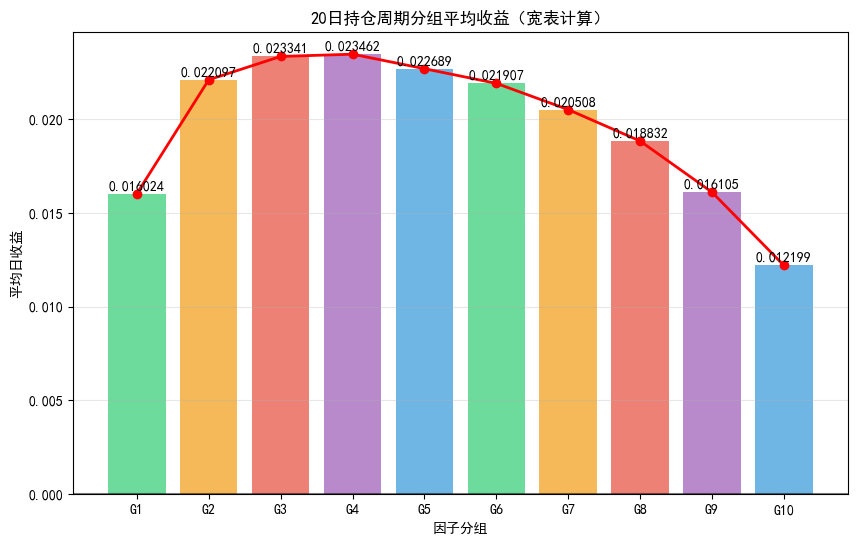

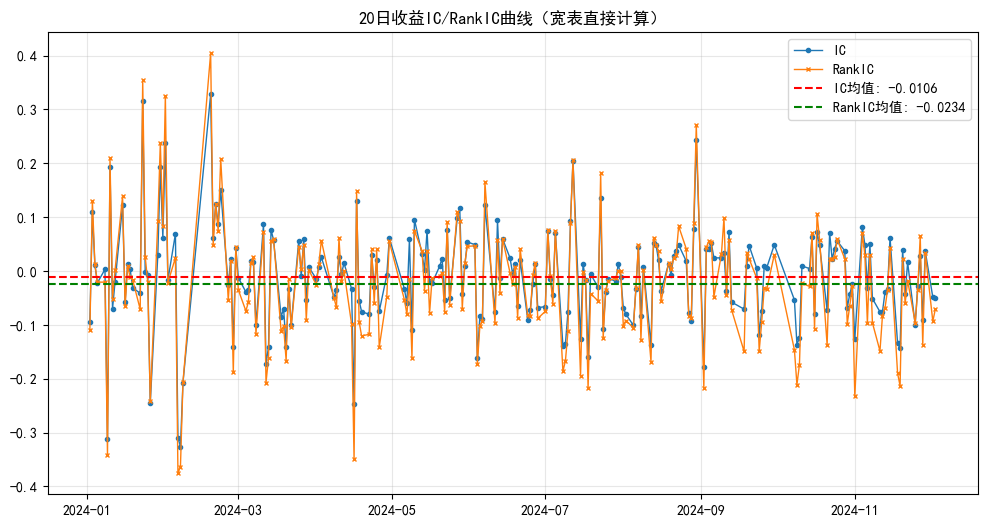

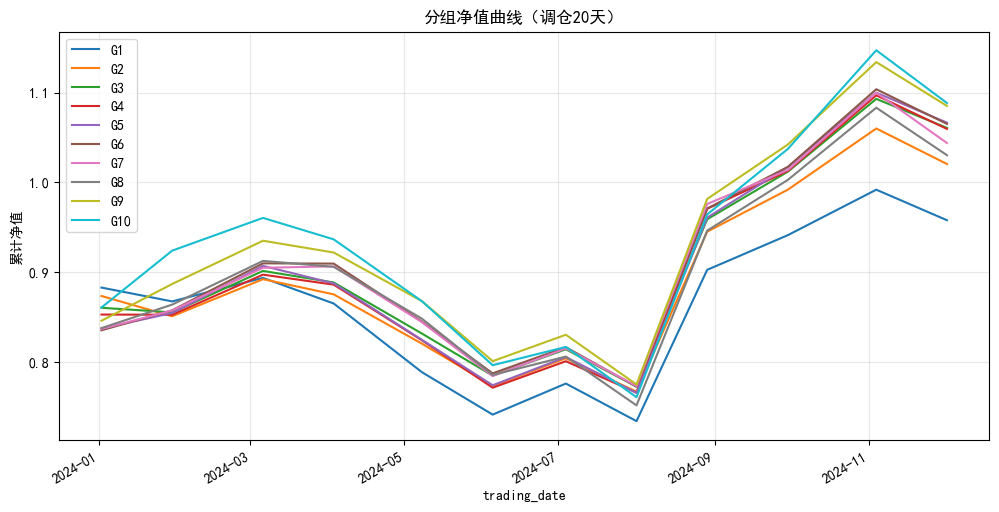

In [ ]:
# 分析因子表现
from alpha import *
performance = analyze_factor(
    factor_data=daily_rskew.to_pandas().pivot(index='trading_date',columns='code',values='rskew_standard'),
    close_data=close,
    start_date=start_date,
    end_date=end_date,
    return_period=20,
    adjust_freq=20,
    group_num=10,
)